# Определение возраста покупателей

Описание проекта:

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта:

Построить модель, которая по фотографии определит приблизительный возраст человека.
Добейтесь значения MAE на тестовой выборке не больше 8.

План выполнения проекта:
* Провести исследовательский анализ набора фотографий;
* Подготовить данные к обучению;
* Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
print(data.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

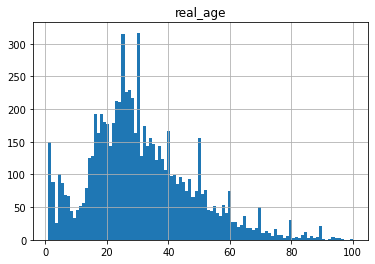

In [4]:
data.hist(bins=100)

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


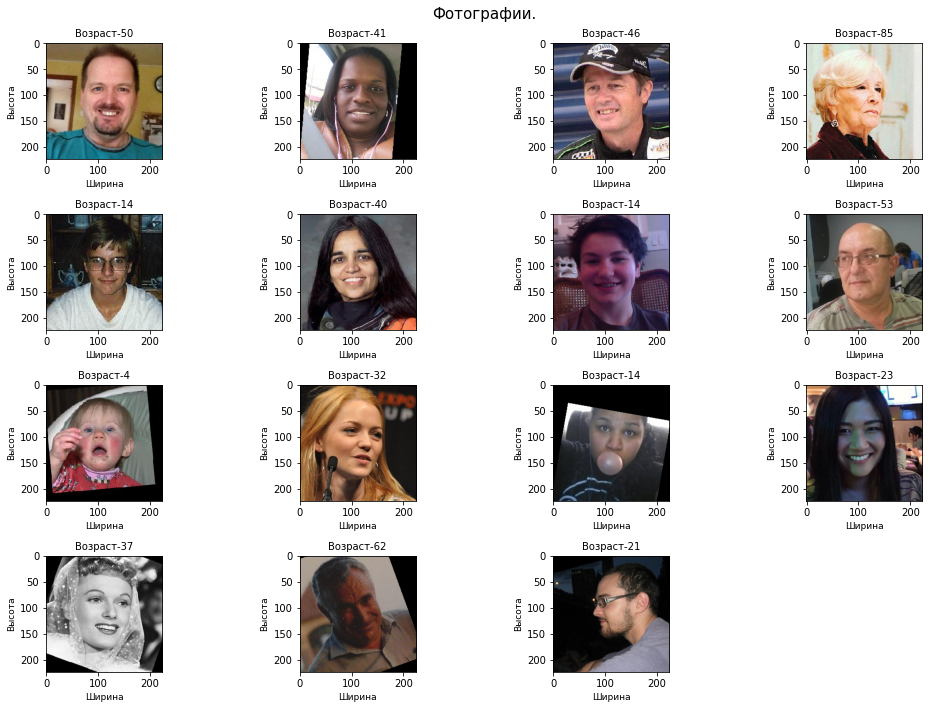

In [7]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.1, hspace=0.95)
for i in range(15):
    plt.suptitle('Фотографии.', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
plt.tight_layout()

Итак, на основе полученных данных можно сделать выводы:
* У нас есть датасет с 7591 фотографией;
* В датасете нет пропусков, а сами данные имеют корректный вид;
* В основном распределение возраста людей в датасете попадает в диапазон от 21 года до 40 лет;
* В датасете присутствуют и цветные, и ЧБ изображения, а также изображения пол углом, хотя масштаб у них не отличается.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

356/356 - 71s - loss: 205.5872 - mae: 10.4621 - val_loss: 504.9953 - val_mae: 17.2453
Epoch 2/10
356/356 - 39s - loss: 84.7870 - mae: 7.0164 - val_loss: 126.9547 - val_mae: 8.4802
Epoch 3/10
356/356 - 38s - loss: 57.2694 - mae: 5.7590 - val_loss: 90.7404 - val_mae: 7.2059
Epoch 4/10
356/356 - 38s - loss: 41.7368 - mae: 4.9033 - val_loss: 73.9247 - val_mae: 6.4697
Epoch 5/10
356/356 - 38s - loss: 30.2795 - mae: 4.2543 - val_loss: 76.4428 - val_mae: 6.5318
Epoch 6/10
356/356 - 38s - loss: 22.7178 - mae: 3.6703 - val_loss: 74.1362 - val_mae: 6.5362
Epoch 7/10
356/356 - 38s - loss: 19.5399 - mae: 3.3832 - val_loss: 101.0888 - val_mae: 7.8776
Epoch 8/10
356/356 - 38s - loss: 17.8146 - mae: 3.2007 - val_loss: 63.8551 - val_mae: 6.0312
Epoch 9/10
356/356 - 38s - loss: 14.8170 - mae: 2.9363 - val_loss: 65.1181 - val_mae: 5.9229
Epoch 10/10
356/356 - 39s - loss: 13.4220 - mae: 2.7888 - val_loss: 66.4064 - val_mae: 6.0842

119/119 - 9s - loss: 66.4064 - mae: 6.0842
Test MAE: 6.0842

```

## Анализ обученной модели

* Была использована модель сверточной нейронной сети на ResNet50;
* Нам удалось добиться поставленной цели - значение метрики MAE на тестовой выборке не больше 8;

Для достижения наилучшего качества модели использовались:
* алгоритм Adam(lr=0.0001);
* архитектура RestNet50(weights='imagenet');
* аугментация данных.